# WGAN-GP
WGAN-GP uses gradient penalty on top of WGAN to remove the Lipschitz constraint.

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

%matplotlib inline
sns.set()

In [2]:
class Critic(nn.Module):
    def __init__(self, channels, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            nn.Conv2d(
                in_channels=channels,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # 32x32
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
            self._block(in_channels=features_d, out_channels=features_d*2, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_d*2, out_channels=features_d*4, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_d*4, out_channels=features_d*8, kernel_size=4, stride=2, padding=1), # 4x4
            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
            ), #1x1
            # nn.Sigmoid(), no sigmoid at last, for wgan, we work with logits
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
#             nn.BatchNorm2d(num_features=out_channels),
            nn.InstanceNorm2d(num_features=out_channels, affine=True), # LayerNorm ~ InstanceNorm, but in the paper they used layernorm, affine=True makes the module learnable
#             nn.LayerNorm(normalized_shape=out_channels, elementwise_affine=True), # elementwise_affine=True makes the module learnable
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
        )
            
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x latent_dim x 1 x 1
            self._block(in_channels=latent_dim, out_channels=features_g*16, kernel_size=4, stride=1, padding=0), # N x f_g*16 x 4 x 4
            self._block(in_channels=features_g*16, out_channels=features_g*8, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_g*8, out_channels=features_g*4, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_g*4, out_channels=features_g*2, kernel_size=4, stride=2, padding=1), # 32x32
            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            nn.ReLU(inplace=True),
        )
            
    def forward(self, x):
        return self.gen(x)

In [4]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def gradient_penalty(critic, real, fake):
    BATCH_SIZE, CHANNELS, HEIGHT, WIDTH = real.shape
    # epsilon should be U[0, 1] which is statisfied by torch.rand
    epsilon = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, CHANNELS, HEIGHT, WIDTH).to(DEVICE) # implies we want only one value for each dimension but we want, it as the shape of the image
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    # calculate the critic score
    mixed_scores = critic(interpolated_images) # we call it mixed scores, as it the scores of the interpolated images
    
    gradient = torch.autograd.grad(inputs=interpolated_images, outputs=mixed_scores, grad_outputs=torch.ones_like(mixed_scores), create_graph=True, retain_graph=True)[0]
    
    gradient.view(gradient.shape[0], -1) # flattenning to take the norm
    
    # norm is basically finding, how big one vector/matrix is to the other
    # l1 norm is the sum of all the absolute components for vectors
    # l2 norm is the sqrt of the sum of squares of all the components for vectors
    
    # l1 and l2 norm have slightly different expression than that of vectors
    
    gradient_norm = gradient.norm(p=2, dim=1,) # l2 norm is used
    
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 32
LEARNING_RATE = 1e-4
LATENT_DIM = 100
CHANNELS = 1
FEATURES_DISC = 64
FEATURES_GEN = 64
IMG_SIZE = 64
BATCH_SIZE = 64
CRITIC_ITERATIONS = 5
GRADIENT_PENALTY_LAMBDA = 10

In [7]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize([5e-1 for _ in range(CHANNELS)], [5e-1 for _ in range(CHANNELS)], inplace=True)]
)

In [8]:
# MNIST
dataset = datasets.MNIST(root='./dataset', download=True, train=True, transform=transform)
CHANNELS = 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [9]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, shuffle=True, pin_memory=True)

In [10]:
fixed_noise = torch.randn((32, LATENT_DIM, 1, 1)).to(DEVICE)

critic = Critic(channels=CHANNELS, features_d=FEATURES_DISC).to(DEVICE)
gen = Generator(latent_dim=LATENT_DIM, channels_img=CHANNELS, features_g=FEATURES_GEN).to(DEVICE)

init_weights(critic)
init_weights(gen)

optim_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0, 9e-1))
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 9e-1))

# training mode
critic.train()
gen.train() 

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [11]:
fake_imgs = []
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real_img, _) in enumerate(loader):
        real_img = real_img.to(DEVICE)
        
        # train the critic: max E[critic(x)] - E[critic(z)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(DEVICE)
            fake_img = gen(noise)
            
            critic_real = critic(real_img).view(-1)
            critic_fake = critic(fake_img.detach()).view(-1)
            
            # gradient penalty
            gp = gradient_penalty(critic, real_img, fake_img)

            lossC = -(torch.mean(critic_real) - torch.mean(critic_fake)) + GRADIENT_PENALTY_LAMBDA * gp

            critic.zero_grad()
            lossC.backward(retain_graph=True)
            optim_critic.step()
            
        # train the generator: min -E[critic(gen(z))]
        output = critic(fake_img).view(-1)
        lossG = -torch.mean(output)
        
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()
                
        if batch_idx == len(loader) - 1:
            print(f'Epoch: [{epoch}/{EPOCHS}] | LossC: {lossC:.4f} | LossG: {lossG:.4f}')
            with torch.inference_mode():
                fake_img = gen(fixed_noise)
                
                img_grid_fake = make_grid(fake_img[:32], normalize=True)

                fake_imgs.append(img_grid_fake)

Epoch: [1/32] | LossC: -5541.3379 | LossG: 3573.8796
Epoch: [2/32] | LossC: -6516.1436 | LossG: 5943.9932
Epoch: [3/32] | LossC: -5001.4844 | LossG: 6080.2383
Epoch: [4/32] | LossC: -5842.6812 | LossG: 7800.6841
Epoch: [5/32] | LossC: -5121.5537 | LossG: 5602.7959
Epoch: [6/32] | LossC: -2892.9822 | LossG: 6796.2266
Epoch: [7/32] | LossC: -3044.1802 | LossG: 7293.1582
Epoch: [8/32] | LossC: -3447.8354 | LossG: 9389.4277
Epoch: [9/32] | LossC: -4095.7808 | LossG: 6078.2422
Epoch: [10/32] | LossC: -2400.9365 | LossG: 9455.7061
Epoch: [11/32] | LossC: -1559.8347 | LossG: 9439.9668
Epoch: [12/32] | LossC: -2081.2410 | LossG: 9033.3496
Epoch: [13/32] | LossC: -1219.6296 | LossG: 8393.4033
Epoch: [14/32] | LossC: -3278.5586 | LossG: 8588.0586
Epoch: [15/32] | LossC: -1723.1823 | LossG: 8714.7852
Epoch: [16/32] | LossC: -2499.3242 | LossG: 8208.4902
Epoch: [17/32] | LossC: -1677.2578 | LossG: 8474.5713
Epoch: [18/32] | LossC: -1192.2565 | LossG: 7551.8213
Epoch: [19/32] | LossC: -1389.5366 | 

(-0.5, 529.5, 265.5, -0.5)

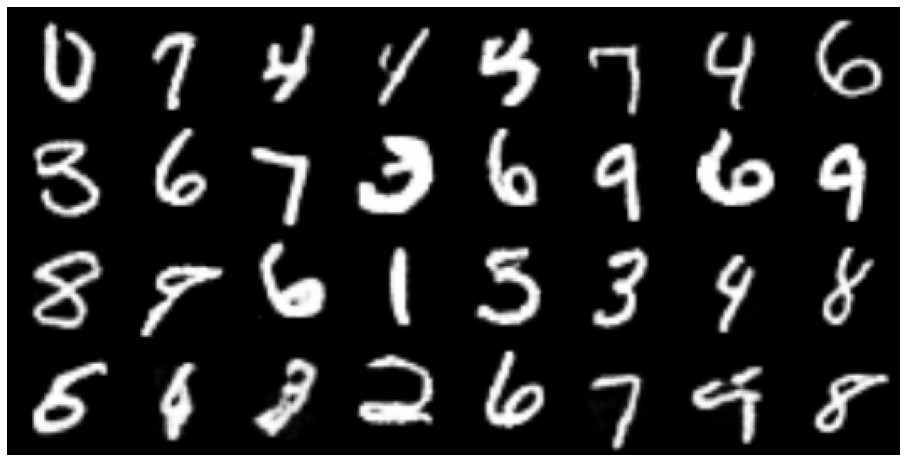

In [12]:
plt.figure(figsize=(16, 16))
plt.imshow(fake_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')